# Notebook used to create our NTDB Mortality Prediction paper. 
Tsiklidis EJ, Sims C, Sinno T, Diamond SL (2020) Using the National Trauma Data Bank (NTDB) and machine learning to predict trauma patient mortality at admission. PLOS ONE 15(11): e0242166. https://doi.org/10.1371/journal.pone.0242166

In [1]:
#Import python libraries
from __future__ import print_function  
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt
 
import sklearn
import sklearn.ensemble
import scipy.interpolate
import scipy.integrate
import os 
import shap
import graphviz 
import pickle
from scipy import stats
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer # explicitly require this experimental feature
from sklearn.impute import IterativeImputer # now you can import normally from sklearn.impute
from impyute.imputation.cs import fast_knn
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import tree
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
import ntdb_utils as utils
from functools import reduce

os.environ['KMP_DUPLICATE_LIB_OK']='True'
ran  = 100
np.random.seed(ran)

In [2]:
import imblearn
print(imblearn.__version__)

0.7.0


In [3]:
#parameter specification
lb_make = LabelEncoder()
training_percent = 0.85
learning_rate = 0.08 #Determined by Grid Search Cross Validation
random_state = ran

sklearn_imputation_flag = 0
sklearn_imputation_strat = 'mean'
iter_imputation_flag = 1
random_sample_flag = 0
datawig_flag = 0
fast_knn_flag = 0
test_set_imp_flag = 1
train_set_imp_flag = 1

In [4]:
#######################################################################
#Import datatables
os.chdir(os.getcwd() + '/NTDB_DATA')
RDS_AISDES_df = pd.read_csv('RDS_AISDES.csv') 

#The AIS© (Abbreviated Injury Scale) code version 1980, 1985, 1990, and 1998 
#submitted by the hospital for the trauma diagnosis
RDS_AISPCODE_df = pd.read_csv('RDS_AISPCODE.csv')

#Information pertaining to any pre-existing comorbid conditions a patient had 
#upon arrival in the ED/hospital
RDS_COMORBID_df = pd.read_csv('RDS_COMORBID.csv')

#Information pertaining to any complications during the course of patient treatment
RDS_COMPLIC_df = pd.read_csv('RDS_COMPLIC.csv')

#Includes the ICD-9-CM diagnosis codes
RDS_DCODE_df = pd.read_csv('RDS_DCODE.csv')

#Lookup table ICD-9-CM diagnoses codes
RDS_DCODEDES_df = pd.read_csv('RDS_DCODEDES.csv')

#Includes information about the patient and incident demographics
rds_demo_df = pd.read_csv('rds_demo.csv')

#Includes discharge information
RDS_DISCHARGE_df = pd.read_csv('RDS_DISCHARGE.csv')

#Includes ICD-9-CM E-Codes (Mechanism of Injury)
RDS_ECODE_df = pd.read_csv('RDS_ECODE.csv')

#Look-up table for ICD-9-CM E-Codes
RDS_ECODEDES_df = pd.read_csv('RDS_ECODEDES.csv')

#ED and Injury information
RDS_ED_df = pd.read_csv('RDS_ED.csv')

#Includes the ICD-10-CM diagnosis codes
RDS_ICD10_DCODE_df = pd.read_csv('RDS_ICD10_DCODE.csv')

#RDS_ICD10_DCODEDES_df = pd.read_csv('RDS_ICD10_DCODEDES.csv')

#Includes ICD-10-CM E-Codes (Mechanism of Injury)
RDS_ICD10_ECODE_df = pd.read_csv('RDS_ICD10_ECODE.csv')

#Look-up table for ICD-10-CM E-Codes
RDS_ICD10_ECODEDES_df = pd.read_csv('RDS_ICD10_ECODEDES.csv')

#Includes ICD-10-CM Location Codes
RDS_ICD10_LOC_df = pd.read_csv('RDS_ICD10_LOC.csv')

#Lookup table ICD-10-CM location codes
RDS_RDS_ICD10_LOCDES_df = pd.read_csv('RDS_ICD10_LOCDES.csv')

#Lookup table ICD-10-CM procedure codes
RDS_ICD10_PCODEDES_df = pd.read_csv('RDS_ICD10_PCODEDES.csv')

#ICD-9-CM and ICD-10-CM procedure codes
RDS_PCODE_df = pd.read_csv('RDS_PCODE.csv')

#Look-up table for ICD-9-CM Procedure Codes
RDS_PCODEDES_df = pd.read_csv('RDS_PCODEDES.csv')

#Information on protective devices
RDS_PROTDEV_df = pd.read_csv('RDS_PROTDEV.csv')

#Information on mode of transportation to the ED
RDS_TRANSPORT_df = pd.read_csv('RDS_TRANSPORT.csv')

#Information on patient vital signs for both EMS and ED 
RDS_VITALS_df = pd.read_csv('RDS_VITALS.csv')

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


In [5]:
##############################################################################
#Which columns to keep
##############################################################################
rds_demo_df = rds_demo_df[['INC_KEY','AGE','GENDER']]
RDS_VITALS_df = RDS_VITALS_df[['INC_KEY','SBP','PULSE','RR','OXYSAT','TEMP','GCSTOT']]
RDS_DISCHARGE_df = RDS_DISCHARGE_df[['INC_KEY','HOSPDISP']]

In [6]:
#Convert comorbidity information into mutually exclusive binary inputs. 
RDS_COMORBID_df = utils.mutually_exclusive_df(RDS_COMORBID_df.INC_KEY,RDS_COMORBID_df.COMORDES)
RDS_COMORBID_df.rename(columns = {'Other':'Other COMORBID','Not Applicable BIU 1':'COMORBID_NOT_APPLICABLE',\
                                'Not Known/Not Recorded BIU 2':'COMORBID_NOT_KNOWN/RECOREDED'},inplace='True')
RDS_COMORBID_df = RDS_COMORBID_df.reset_index()

In [7]:
##############################################################################
#Merging datasets into 1 data file. 
##############################################################################
dfs = [rds_demo_df,RDS_VITALS_df,RDS_DISCHARGE_df,RDS_COMORBID_df]
merged_data_df = utils.merge_mutliple_dfs(dfs,['INC_KEY'],'inner')

In [8]:
numINCS = merged_data_df.INC_KEY.unique().shape[0]
print('Number of unique incident keys is ' + str(numINCS))

Number of unique incident keys is 968665


In [9]:
all_data_inc_missing = merged_data_df.copy()
all_data_inc_missing = all_data_inc_missing.drop_duplicates(subset='INC_KEY')

In [10]:
##################################
#Filtering missing data
##################################
merged_data_df = merged_data_df[merged_data_df['GENDER'].str.len().lt(10)] 
merged_data_df = utils.filterRealVals(merged_data_df,['AGE','SBP','PULSE','RR','OXYSAT','GCSTOT','TEMP'])

In [11]:
#Remove entries where the outcome is unknown! 
rem_list = ['Not Applicable BIU 1','Not Known/Not Recorded BIU 2',]
merged_data_df = utils.removeUnknownOutcomes(merged_data_df,'HOSPDISP',rem_list)

In [12]:
#label encode the categorical information. 
merged_data_df = utils.encode(merged_data_df,['GENDER','HOSPDISP'])

In [13]:
#Remove features that will not be used for prediction. 
rem_list = ['OUTCOME','INC_KEY','HOSPDISP_CODE','HOSPDISP','COMORBID_NOT_APPLICABLE',\
            'COMORBID_NOT_KNOWN/RECOREDED','OtherCOMORBID']
merged_data_df.columns = merged_data_df.columns.str.replace(' ', '')
feature_list = utils.construct_feature_list(merged_data_df.columns,rem_list)
clean_data_df = merged_data_df[['INC_KEY','OUTCOME'] + feature_list]
print('AFTER dropping duplicate inc_key, number of patients is : ' + str(clean_data_df.shape[0]))

AFTER dropping duplicate inc_key, number of patients is : 618396


In [14]:
print('Ratio of survival to deceased is ' + str(np.sum(clean_data_df.OUTCOME.values)) + ' / ' + str(clean_data_df.shape[0]))

Ratio of survival to deceased is 604468 / 618396


In [15]:
train_df,test_df = utils.train_test_creator_CI(clean_data_df,training_percent,'OUTCOME')
print('finished constructing merged_data_df')

finished constructing merged_data_df


In [16]:
train_df.head()

,INC_KEY,OUTCOME,AGE,GENDER,SBP,PULSE,RR,OXYSAT,TEMP,GCSTOT,...,Disseminatedcancer,Drugusedisorder,Functionallydependenthealthstatus,HistoryofPeripheralVascularDisease(PVD),Historyofanginawithin30days,Historyofmyocardialinfarction,Hypertensionrequiringmedication,Majorpsychiatricillness,Prematurity,Steroiduse
0,160505668,1,71,1,166.0,107.0,23,98,36.7,15,...,0,0,0,0,0,0,1,0,0,0
1,160310052,0,75,1,194.0,62.0,20,100,35.7,13,...,0,0,0,0,0,0,1,0,0,0
2,160044969,1,74,0,127.0,84.0,16,99,36.8,15,...,0,0,0,0,0,0,0,1,0,0
3,160216202,1,28,1,152.0,63.0,18,97,36.9,15,...,0,0,0,0,0,0,0,0,0,0
4,160938829,0,80,1,102.0,63.0,18,92,36.9,15,...,0,0,0,0,0,0,1,0,0,0


In [17]:
test_df.head()

,INC_KEY,OUTCOME,AGE,GENDER,SBP,PULSE,RR,OXYSAT,TEMP,GCSTOT,...,Disseminatedcancer,Drugusedisorder,Functionallydependenthealthstatus,HistoryofPeripheralVascularDisease(PVD),Historyofanginawithin30days,Historyofmyocardialinfarction,Hypertensionrequiringmedication,Majorpsychiatricillness,Prematurity,Steroiduse
0,160089353,1,33,0,106.0,92.0,22,95,36.8,15,...,0,0,0,0,0,0,0,0,0,0
1,160117877,1,41,1,151.0,97.0,20,98,37.0,15,...,0,0,0,0,0,0,0,0,0,0
2,160964271,1,27,1,94.0,98.0,24,90,34.4,8,...,0,0,0,0,0,0,0,0,0,0
3,160660869,1,80,1,155.0,93.0,16,95,36.1,15,...,0,0,0,0,0,0,1,0,0,0
4,160800419,1,55,1,124.0,110.0,18,98,36.7,15,...,0,0,0,0,0,0,1,0,0,0


In [18]:
missing_data_df = utils.getMissingData(all_data_inc_missing,clean_data_df)

## Let's do some analysis of the missing data

In [19]:
#Incident keys of patients who contained missing data. 
missing_data_inckeys = pd.DataFrame(missing_data_df.INC_KEY)
missing_data_inckeys

,INC_KEY
0,160789265
6,160789267
14,160788894
16,160684943
20,160873553
...,...
1937306,160853113
1937312,160504734
1937314,160323966
1937318,160504738


In [20]:
#Vital sign information from missing data patients. 
missing_data_info = missing_data_inckeys.merge(pd.read_csv('RDS_VITALS.csv'),left_on='INC_KEY',right_on='INC_KEY',how='inner')
missing_data_info.head(5)

,INC_KEY,VSTYPE,SBP,PULSE,RR,OXYSAT,SUPPOXY,TEMP,GCSEYE,GCSVERB,GCSMOT,GCSTOT,GCS_Q1,GCS_Q2,GCS_Q3,RRAQ
0,160789265,EMS,117.0,107.0,18,94,Not Known/Not Recorded BIU 2,-2.0,4,4,5,13,Not Known/Not Recorded BIU 2,Not Known/Not Recorded BIU 2,Not Known/Not Recorded BIU 2,Not Known/Not Recorded BIU 2
1,160789265,ED,140.0,115.0,18,93,No Supplemental Oxygen,36.6,4,4,5,13,"Valid GCS: Patient was not sedated, not intub...",Not Known/Not Recorded BIU 2,Not Known/Not Recorded BIU 2,Unassisted Respiratory Rate
2,160789267,EMS,98.0,71.0,16,95,Not Known/Not Recorded BIU 2,-2.0,2,2,4,8,Not Known/Not Recorded BIU 2,Not Known/Not Recorded BIU 2,Not Known/Not Recorded BIU 2,Not Known/Not Recorded BIU 2
3,160789267,ED,115.0,85.0,15,96,No Supplemental Oxygen,-2.0,4,4,5,13,"Valid GCS: Patient was not sedated, not intub...",Not Known/Not Recorded BIU 2,Not Known/Not Recorded BIU 2,Unassisted Respiratory Rate
4,160788894,EMS,-1.0,-1.0,-1,-1,Not Known/Not Recorded BIU 2,-2.0,-1,-1,-1,-1,Not Known/Not Recorded BIU 2,Not Known/Not Recorded BIU 2,Not Known/Not Recorded BIU 2,Not Known/Not Recorded BIU 2


In [21]:
feature_list_missing_data = ['AGE','GCSTOT','PULSE','SBP','TEMP','GENDER','RR','OXYSAT','HOSPDISP']

In [22]:
og_missing_data_df = missing_data_df.copy()

In [23]:
missing_data_df = missing_data_df[feature_list_missing_data]
missing_data_df.head(5)

,AGE,GCSTOT,PULSE,SBP,TEMP,GENDER,RR,OXYSAT,HOSPDISP
0,47,13,107.0,117.0,-2.0,Male,18,94,Not Applicable BIU 1
6,44,8,71.0,98.0,-2.0,Female,16,95,Discharged to home or self-care (routine disch...
14,63,-1,-1.0,-1.0,-2.0,Male,-1,-1,Not Applicable BIU 1
16,86,-2,-2.0,-2.0,-2.0,Female,-2,-2,Discharged/Transferred to Skilled Nursing Faci...
20,-99,-1,-1.0,-1.0,-2.0,Female,-1,-1,Discharged to home or self-care (routine disch...


In [24]:
missing_data_df = utils.encode(missing_data_df,['HOSPDISP'])

In [25]:
feature_list_missing_data = ['AGE','GCSTOT','PULSE','SBP','TEMP','GENDER','RR','OXYSAT','OUTCOME']
missing_data_df = missing_data_df[feature_list_missing_data]
missing_data_df.head(5)

,AGE,GCSTOT,PULSE,SBP,TEMP,GENDER,RR,OXYSAT,OUTCOME
0,47,13,107.0,117.0,-2.0,Male,18,94,1
6,44,8,71.0,98.0,-2.0,Female,16,95,1
14,63,-1,-1.0,-1.0,-2.0,Male,-1,-1,1
16,86,-2,-2.0,-2.0,-2.0,Female,-2,-2,1
20,-99,-1,-1.0,-1.0,-2.0,Female,-1,-1,1


In [26]:
missing_data_df.GENDER.value_counts()

Male                            206338
Female                          143786
Not Known/Not Recorded BIU 2       145
Name: GENDER, dtype: int64

In [27]:
mode = missing_data_df.GENDER.value_counts().keys().tolist()[0]
missing_data_df.loc[missing_data_df['GENDER']  == 'Not Known/Not Recorded BIU 2', 'GENDER'] = mode

In [28]:
missing_data_df["GENDER"] = lb_make.fit_transform(missing_data_df["GENDER"])

In [29]:
missing_data_df[missing_data_df<0] = np.nan

In [30]:
missing_data_df.head(5)

,AGE,GCSTOT,PULSE,SBP,TEMP,GENDER,RR,OXYSAT,OUTCOME
0,47.0,13.0,107.0,117.0,NaN,1,18.0,94.0,1
6,44.0,8.0,71.0,98.0,NaN,0,16.0,95.0,1
14,63.0,NaN,NaN,NaN,NaN,1,NaN,NaN,1
16,86.0,NaN,NaN,NaN,NaN,0,NaN,NaN,1
20,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,1


In [31]:
clean_data_df.shape

(618396, 34)

In [32]:
missing_data_df.shape

(350269, 9)

In [33]:
1 - missing_data_df.OUTCOME.sum() / missing_data_df.shape[0]

0.03251500989239697

## Let's implement an iterative imputation approach for the missing data

In [34]:
utils.printMissingBreakdown(missing_data_df,feature_list_missing_data)

AGE is missing 56834 out of its 350269 entries
GCSTOT is missing 158097 out of its 350269 entries
PULSE is missing 152736 out of its 350269 entries
SBP is missing 158467 out of its 350269 entries
TEMP is missing 338503 out of its 350269 entries
GENDER is missing 0 out of its 350269 entries
RR is missing 159091 out of its 350269 entries
OXYSAT is missing 194485 out of its 350269 entries
OUTCOME is missing 0 out of its 350269 entries


In [35]:
#construct missing_flags function
missing_flags = utils.construct_missing_flags(missing_data_df)

In [36]:
#Breakdown of NUMBER of patients missing certain number of data. 
missing_flags['sum'].value_counts()

6    125132
1    116020
2     60420
7     22257
3     14687
0      4983
5      3621
4      3149
Name: sum, dtype: int64

# Based on these value counts, we should divide around 2.5 missing features. Let's print some data about the patients missing more than 2.5 featues though! 

In [37]:
utils.excludedDataStats(missing_data_df,missing_flags,2.5)

Death rate of exluded data is 0.02596448835033105


In [38]:
missing_flags = missing_flags[missing_flags['sum'] < 2.5]
missing_flags['sum'].value_counts()

1    116020
2     60420
0      4983
Name: sum, dtype: int64

In [39]:
missing_data_df = utils.dataToImpute(missing_data_df,missing_flags,feature_list_missing_data)

count    618396.000000
mean         49.037605
std          24.223748
min           1.000000
25%          28.000000
50%          51.000000
75%          70.000000
max          89.000000
Name: AGE, dtype: float64


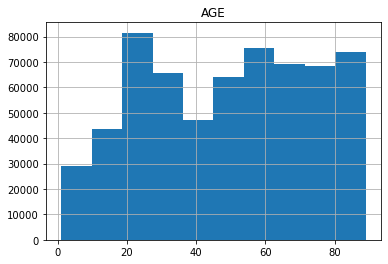

count    618396.000000
mean         14.328178
std           2.301405
min           3.000000
25%          15.000000
50%          15.000000
75%          15.000000
max          15.000000
Name: GCSTOT, dtype: float64


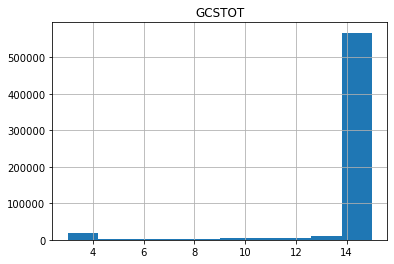

count    618396.000000
mean         88.709877
std          20.023407
min           1.000000
25%          75.000000
50%          87.000000
75%         100.000000
max         247.000000
Name: PULSE, dtype: float64


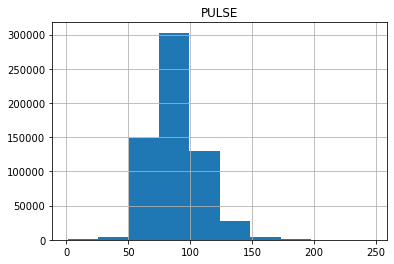

count    618396.000000
mean        138.007523
std          25.902151
min           1.000000
25%         121.000000
50%         136.000000
75%         153.000000
max         300.000000
Name: SBP, dtype: float64


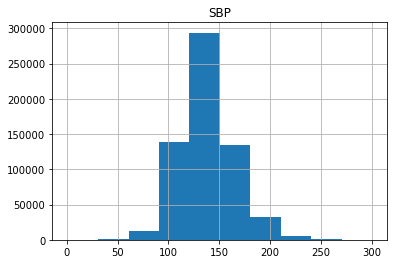

count    618396.000000
mean         36.659752
std           0.775030
min           1.000000
25%          36.400000
50%          36.700000
75%          36.900000
max          45.000000
Name: TEMP, dtype: float64


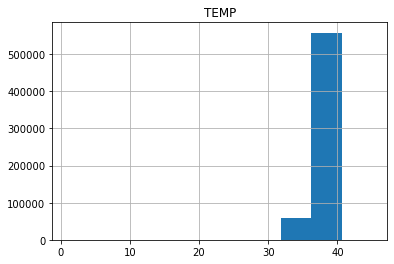

count    618396.000000
mean          0.612412
std           0.487200
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: GENDER, dtype: float64


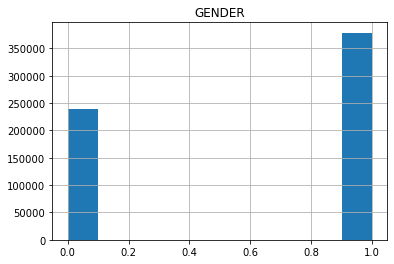

count    618396.000000
mean         18.782376
std           4.372315
min           1.000000
25%          16.000000
50%          18.000000
75%          20.000000
max          99.000000
Name: RR, dtype: float64


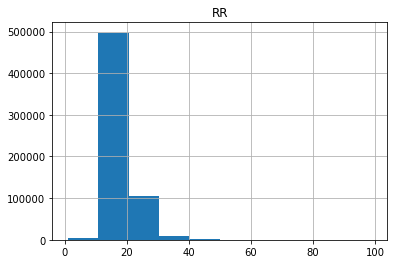

count    618396.000000
mean         97.185541
std           4.003474
min           1.000000
25%          96.000000
50%          98.000000
75%         100.000000
max         100.000000
Name: OXYSAT, dtype: float64


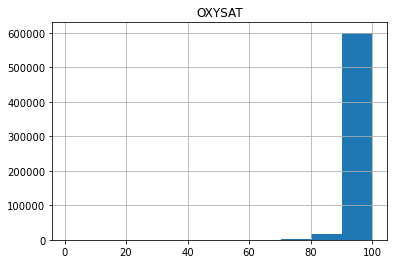

In [40]:
#function here to plot next two. 
utils.hist(clean_data_df,['AGE','GCSTOT','PULSE','SBP','TEMP','GENDER','RR','OXYSAT'])

count    156712.000000
mean         44.722459
std          23.492060
min           1.000000
25%          25.000000
50%          43.000000
75%          64.000000
max          89.000000
Name: AGE, dtype: float64


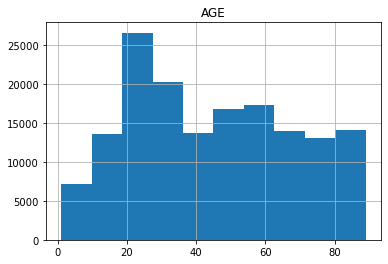

count    175767.000000
mean         13.577771
std           3.337629
min           3.000000
25%          14.000000
50%          15.000000
75%          15.000000
max          15.000000
Name: GCSTOT, dtype: float64


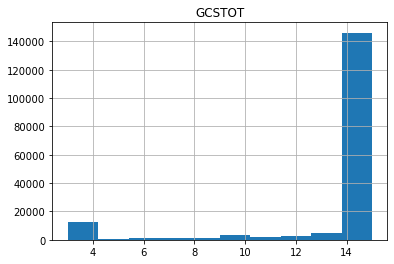

count    181012.000000
mean         90.205870
std          25.606843
min           0.000000
25%          76.000000
50%          90.000000
75%         104.000000
max         288.000000
Name: PULSE, dtype: float64


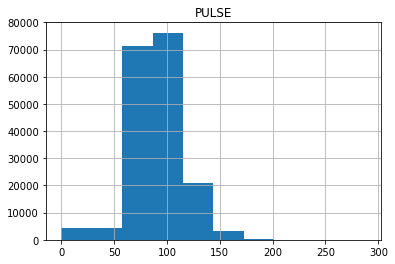

count    178729.000000
mean        135.020506
std          36.132597
min           0.000000
25%         119.000000
50%         137.000000
75%         155.000000
max         300.000000
Name: SBP, dtype: float64


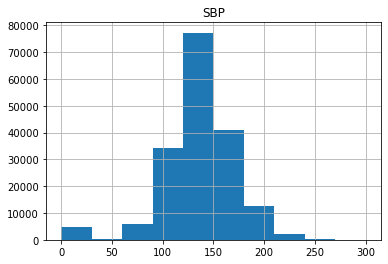

count    11618.000000
mean        36.608977
std          1.629120
min          0.000000
25%         36.400000
50%         36.700000
75%         36.900000
max         41.400000
Name: TEMP, dtype: float64


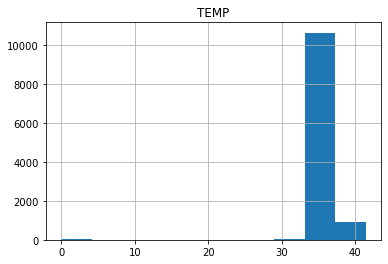

count    181423.000000
mean          0.588233
std           0.492155
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: GENDER, dtype: float64


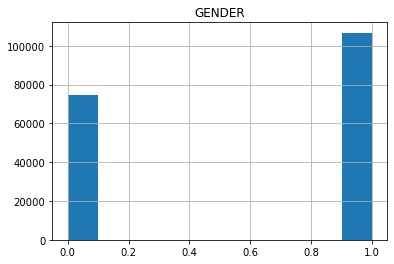

count    177761.000000
mean         18.040088
std           5.923473
min           0.000000
25%          16.000000
50%          18.000000
75%          20.000000
max          99.000000
Name: RR, dtype: float64


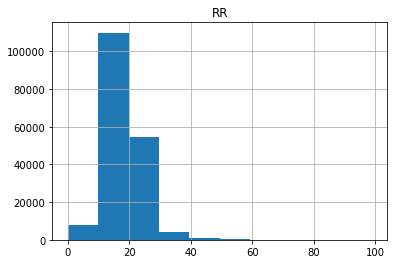

count    151502.000000
mean         94.820379
std          13.100186
min           0.000000
25%          95.000000
50%          98.000000
75%          99.000000
max         100.000000
Name: OXYSAT, dtype: float64


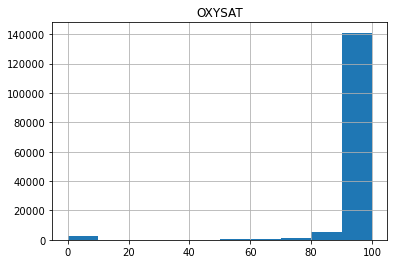

In [41]:
utils.hist(missing_data_df,['AGE','GCSTOT','PULSE','SBP','TEMP','GENDER','RR','OXYSAT'])

In [42]:
#imputation of missing data. 
if iter_imputation_flag == 1: 
    imp = IterativeImputer(max_iter=50)
    imp.fit(clean_data_df[feature_list_missing_data])
    missing_data_imputed_df = pd.DataFrame(imp.transform(missing_data_df),columns = feature_list_missing_data)
    missing_data_imputed_df = np.round(missing_data_imputed_df)
    missing_data_imputed_df.head(5)

In [43]:
#check to make sure every element has been imputed. 
utils.printMissingBreakdown(missing_data_imputed_df,feature_list_missing_data)

AGE is missing 0 out of its 181423 entries
GCSTOT is missing 0 out of its 181423 entries
PULSE is missing 0 out of its 181423 entries
SBP is missing 0 out of its 181423 entries
TEMP is missing 0 out of its 181423 entries
GENDER is missing 0 out of its 181423 entries
RR is missing 0 out of its 181423 entries
OXYSAT is missing 0 out of its 181423 entries
OUTCOME is missing 0 out of its 181423 entries


count    181423.000000
mean         46.724660
std          23.287926
min         -40.000000
25%          26.000000
50%          48.000000
75%          65.000000
max         192.000000
Name: AGE, dtype: float64


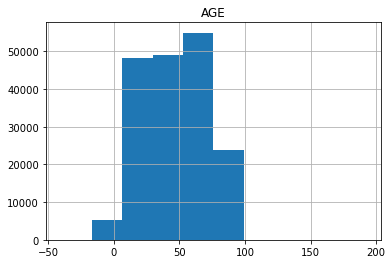

count    181423.000000
mean         13.601225
std           3.292421
min           3.000000
25%          14.000000
50%          15.000000
75%          15.000000
max          16.000000
Name: GCSTOT, dtype: float64


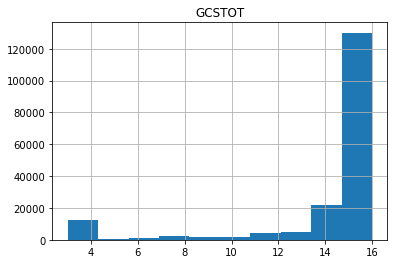

count    181423.000000
mean         90.205547
std          25.582048
min           0.000000
25%          76.000000
50%          90.000000
75%         104.000000
max         288.000000
Name: PULSE, dtype: float64


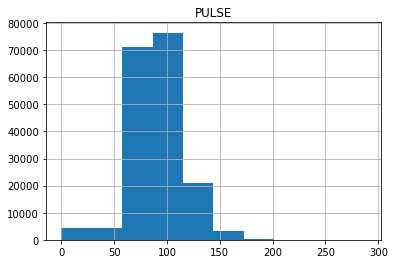

count    181423.000000
mean        134.924265
std          35.890635
min           0.000000
25%         119.000000
50%         136.000000
75%         154.000000
max         300.000000
Name: SBP, dtype: float64


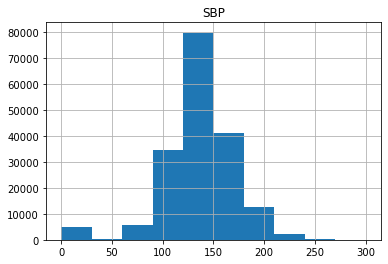

count    181423.000000
mean         36.851832
std           0.537152
min           0.000000
25%          37.000000
50%          37.000000
75%          37.000000
max          41.000000
Name: TEMP, dtype: float64


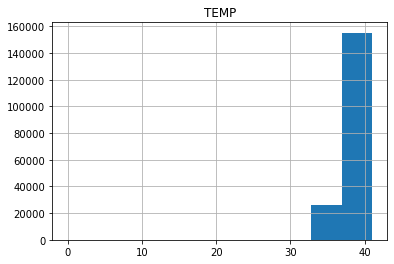

count    181423.000000
mean          0.588233
std           0.492155
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: GENDER, dtype: float64


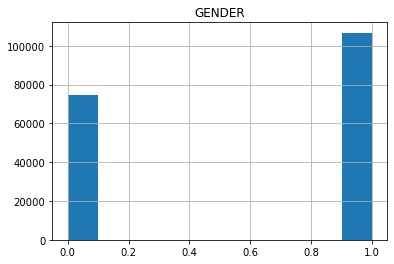

count    181423.000000
mean         18.060604
std           5.868836
min           0.000000
25%          16.000000
50%          18.000000
75%          20.000000
max          99.000000
Name: RR, dtype: float64


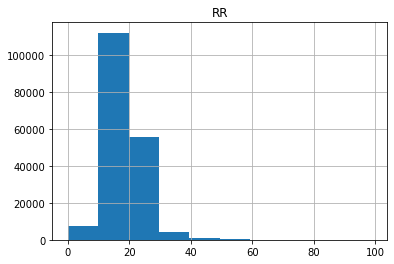

count    181423.000000
mean         95.225897
std          12.013106
min           0.000000
25%          96.000000
50%          98.000000
75%          99.000000
max         102.000000
Name: OXYSAT, dtype: float64


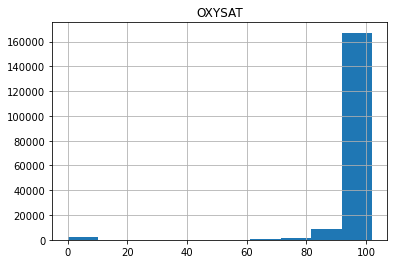

In [44]:
#breakdown of imputed missing data.
utils.hist(missing_data_imputed_df,['AGE','GCSTOT','PULSE','SBP','TEMP','GENDER','RR','OXYSAT'])

In [45]:
#Some obviouus imputation issues that need to be fixed. <1 imputed as 5. Chosen instead of mode since negative
#value could suggest that age should have been relatively small. Likewise for upper age of age, GCSTOT and OXYSAT. 
missing_data_imputed_df.loc[missing_data_imputed_df['AGE'] < 1, 'AGE'] = 5
missing_data_imputed_df.loc[missing_data_imputed_df['AGE'] > 89, 'AGE'] = 89
missing_data_imputed_df.loc[missing_data_imputed_df['GCSTOT'] > 15, 'GCSTOT'] = 15
missing_data_imputed_df.loc[missing_data_imputed_df['OXYSAT'] > 100, 'OXYSAT'] = 100

count    181423.000000
mean         46.681882
std          23.080673
min           1.000000
25%          26.000000
50%          48.000000
75%          65.000000
max          89.000000
Name: AGE, dtype: float64


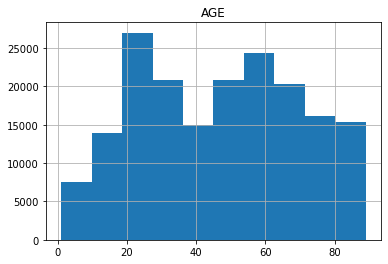

count    181423.000000
mean         13.601203
std           3.292408
min           3.000000
25%          14.000000
50%          15.000000
75%          15.000000
max          15.000000
Name: GCSTOT, dtype: float64


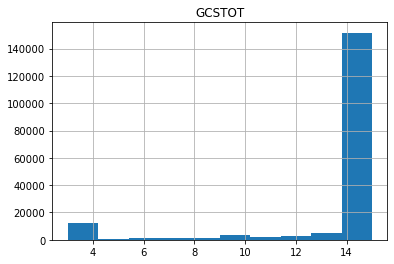

count    181423.000000
mean         90.205547
std          25.582048
min           0.000000
25%          76.000000
50%          90.000000
75%         104.000000
max         288.000000
Name: PULSE, dtype: float64


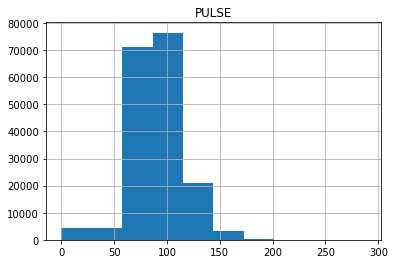

count    181423.000000
mean        134.924265
std          35.890635
min           0.000000
25%         119.000000
50%         136.000000
75%         154.000000
max         300.000000
Name: SBP, dtype: float64


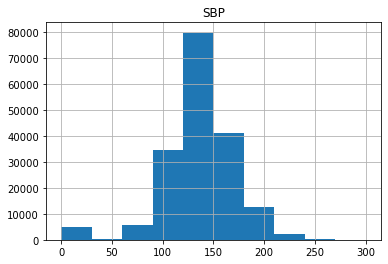

count    181423.000000
mean         36.851832
std           0.537152
min           0.000000
25%          37.000000
50%          37.000000
75%          37.000000
max          41.000000
Name: TEMP, dtype: float64


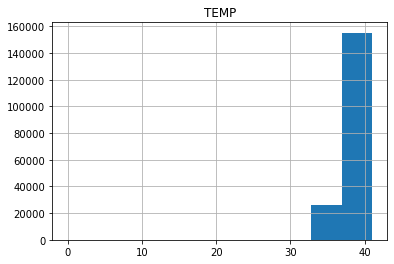

count    181423.000000
mean          0.588233
std           0.492155
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: GENDER, dtype: float64


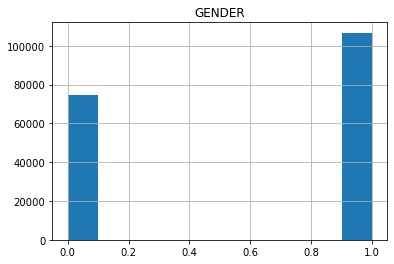

count    181423.000000
mean         18.060604
std           5.868836
min           0.000000
25%          16.000000
50%          18.000000
75%          20.000000
max          99.000000
Name: RR, dtype: float64


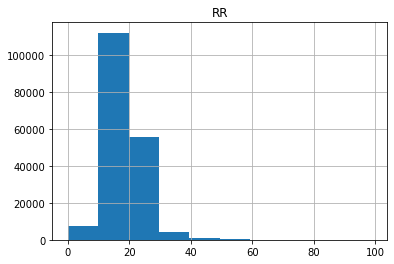

count    181423.000000
mean         95.225870
std          12.013093
min           0.000000
25%          96.000000
50%          98.000000
75%          99.000000
max         100.000000
Name: OXYSAT, dtype: float64


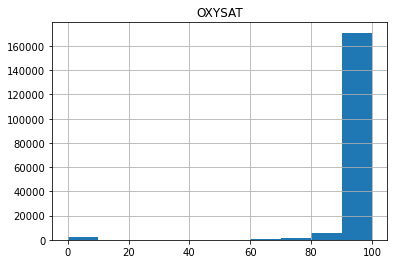

In [46]:
utils.hist(missing_data_imputed_df,['AGE','GCSTOT','PULSE','SBP','TEMP','GENDER','RR','OXYSAT'])

## Let's compare the statistics of the 2 populations

In [47]:
missing_data_imputed_df.describe()

,AGE,GCSTOT,PULSE,SBP,TEMP,GENDER,RR,OXYSAT,OUTCOME
count,181423.000000,181423.000000,181423.000000,181423.000000,181423.000000,181423.000000,181423.000000,181423.000000,181423.000000
mean,46.681882,13.601203,90.205547,134.924265,36.851832,0.588233,18.060604,95.225870,0.961389
std,23.080673,3.292408,25.582048,35.890635,0.537152,0.492155,5.868836,12.013093,0.192668
min,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,14.000000,76.000000,119.000000,37.000000,0.000000,16.000000,96.000000,1.000000
50%,48.000000,15.000000,90.000000,136.000000,37.000000,1.000000,18.000000,98.000000,1.000000
75%,65.000000,15.000000,104.000000,154.000000,37.000000,1.000000,20.000000,99.000000,1.000000
max,89.000000,15.000000,288.000000,300.000000,41.000000,1.000000,99.000000,100.000000,1.000000


In [48]:
clean_data_df[feature_list_missing_data].describe()

,AGE,GCSTOT,PULSE,SBP,TEMP,GENDER,RR,OXYSAT,OUTCOME
count,618396.000000,618396.000000,618396.000000,618396.000000,618396.000000,618396.000000,618396.000000,618396.000000,618396.000000
mean,49.037605,14.328178,88.709877,138.007523,36.659752,0.612412,18.782376,97.185541,0.977477
std,24.223748,2.301405,20.023407,25.902151,0.775030,0.487200,4.372315,4.003474,0.148376
min,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,28.000000,15.000000,75.000000,121.000000,36.400000,0.000000,16.000000,96.000000,1.000000
50%,51.000000,15.000000,87.000000,136.000000,36.700000,1.000000,18.000000,98.000000,1.000000
75%,70.000000,15.000000,100.000000,153.000000,36.900000,1.000000,20.000000,100.000000,1.000000
max,89.000000,15.000000,247.000000,300.000000,45.000000,1.000000,99.000000,100.000000,1.000000


In [49]:
missing_data_df.OUTCOME.value_counts()

1    174418
0      7005
Name: OUTCOME, dtype: int64

In [50]:
feature_list_missing_data = ['INC_KEY'] + feature_list_missing_data

In [51]:
missing_data_imputed_df = missing_data_imputed_df.reset_index()
missing_data_imputed_df.columns = feature_list_missing_data
missing_data_imputed_df.head(5)

,INC_KEY,AGE,GCSTOT,PULSE,SBP,TEMP,GENDER,RR,OXYSAT,OUTCOME
0,0,47.0,13.0,107.0,117.0,37.0,1.0,18.0,94.0,1.0
1,1,44.0,8.0,71.0,98.0,36.0,0.0,16.0,95.0,1.0
2,2,72.0,15.0,64.0,120.0,36.0,0.0,20.0,98.0,0.0
3,3,19.0,15.0,98.0,110.0,37.0,1.0,10.0,98.0,1.0
4,4,10.0,15.0,92.0,118.0,37.0,1.0,12.0,94.0,1.0


In [52]:
#construct missing data.
train_imputation_df,test_imputation_df = utils.train_test_creator_CI(missing_data_imputed_df,training_percent,'OUTCOME')
print('finished constructing imputation datasets')

finished constructing imputation datasets


In [53]:
train_imputation_df.OUTCOME.sum()/train_imputation_df.shape[0]

0.5

In [54]:
train_df.head(5)

,INC_KEY,OUTCOME,AGE,GENDER,SBP,PULSE,RR,OXYSAT,TEMP,GCSTOT,...,Disseminatedcancer,Drugusedisorder,Functionallydependenthealthstatus,HistoryofPeripheralVascularDisease(PVD),Historyofanginawithin30days,Historyofmyocardialinfarction,Hypertensionrequiringmedication,Majorpsychiatricillness,Prematurity,Steroiduse
0,160505668,1,71,1,166.0,107.0,23,98,36.7,15,...,0,0,0,0,0,0,1,0,0,0
1,160310052,0,75,1,194.0,62.0,20,100,35.7,13,...,0,0,0,0,0,0,1,0,0,0
2,160044969,1,74,0,127.0,84.0,16,99,36.8,15,...,0,0,0,0,0,0,0,1,0,0
3,160216202,1,28,1,152.0,63.0,18,97,36.9,15,...,0,0,0,0,0,0,0,0,0,0
4,160938829,0,80,1,102.0,63.0,18,92,36.9,15,...,0,0,0,0,0,0,1,0,0,0


In [55]:
feature_list = ['AGE','GCSTOT','PULSE','SBP','TEMP','GENDER','RR','OXYSAT']

In [56]:
X_train,X_test,y_train,y_test = utils.constructSets(train_df,test_df,feature_list,'OUTCOME')
X_train_imputation,X_test_imputation,y_train_imputation,y_test_imputation = \
utils.constructSets(train_imputation_df,test_imputation_df,feature_list,'OUTCOME')

In [57]:
if train_set_imp_flag == 1: 
    X_train = pd.concat([X_train,X_train_imputation])
    y_train = pd.concat([y_train,y_train_imputation])
if test_set_imp_flag == 1:
    X_test = pd.concat([X_test,X_test_imputation])
    y_test = pd.concat([y_test,y_test_imputation])

In [58]:
#Rescale properties. 
scaler = MinMaxScaler()
scaler.fit(X_train.values)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
#Train model based on the results of the cross validation. 
clf = GradientBoostingClassifier(max_features = 'auto',learning_rate = learning_rate,\
                               loss = 'deviance',n_estimators = 400,subsample = 0.85,max_depth=3,
                                random_state = random_state)
c, r = y_train.values.shape
clf.fit(X_train, y_train.values.reshape(c,))

GradientBoostingClassifier(learning_rate=0.08, max_features='auto',
                           n_estimators=400, random_state=100, subsample=0.85)

In [60]:
y_pred,y_pred_proba = utils.get_auc(X_test,y_test,clf,'TEST')

TEST AUC : 0.9223979217780536


## Shapley numbers : explain specific predictions.. Implementation is shown below.

In [61]:
X = pd.DataFrame(X_train,columns = feature_list)
y_pred2 = clf.predict(X)
labels = y_train
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(clf,feature_perturbation = "tree_path_dependent")
shap_values = explainer.shap_values(X)
X = pd.DataFrame(scaler.inverse_transform(X.values),columns = feature_list)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [62]:

ran_example = np.random.choice(y_pred2.shape[0], 1, replace=False)[0]
print('sample number is ' + str(ran_example))

outc = 'deceased'
if labels.iloc[ran_example][0] == 1:
    outc = 'survived'
print('True outcome is ' + outc)

outc = 'deceased'
if y_pred2[ran_example] == 1: 
    outc = 'survived'
print('Predicted outcome is ' + outc)


plt.figure()
shap.force_plot(explainer.expected_value, shap_values[ran_example,:], X.iloc[ran_example,:],\
                plot_cmap=["#0000ff","#FF0000"])

sample number is 28933
True outcome is survived
Predicted outcome is survived


<Figure size 432x288 with 0 Axes>

In [63]:
y_pred_proba1 = y_pred_proba
labels_test1 = y_test.values

In [64]:
index_dead_p = np.where(y_pred < 0.5)[0]
index_dead_p_df = pd.DataFrame(data=index_dead_p)
index_dead_p_df.columns = ['ind']

X_train,X_test,y_train,y_test = utils.constructSets(train_df,test_df,feature_list,'OUTCOME')
X_train_imputation,X_test_imputation,y_train_imputation,y_test_imputation = \
utils.constructSets(train_imputation_df,test_imputation_df,feature_list,'OUTCOME')

X_train,y_train = utils.combineSets(X_train,X_train_imputation,y_train,y_train_imputation,train_set_imp_flag) 
X_test,y_test = utils.combineSets(X_test,X_test_imputation,y_test,y_test_imputation,test_set_imp_flag)

X_test = X_test.reset_index(drop=True)
X_test = X_test.reset_index()

y_test_vals = y_test.values
pred_dead_df = index_dead_p_df.merge(X_test,left_on = 'ind',right_on = \
                           'index', how = 'inner')

true_outcome = []
for m in index_dead_p:
    true_outcome.append(y_test_vals[m][0])
prob_outcome = []
for m in index_dead_p:
    prob_outcome.append(y_pred_proba[m])


pred_dead_df['predicted_outcome_prob'] = prob_outcome
pred_dead_df['true_outcome'] = true_outcome

true_death_pred = pred_dead_df[pred_dead_df['true_outcome'] == 0]
false_death_pred = pred_dead_df[pred_dead_df['true_outcome'] == 1]
true_death_pred = true_death_pred[['predicted_outcome_prob','true_outcome']+feature_list]
false_death_pred = false_death_pred[['predicted_outcome_prob','true_outcome']+feature_list]

In [65]:
index_surv_p = np.where(y_pred > 0.5)[0]
index_surv_p_df = pd.DataFrame(data=index_surv_p)
index_surv_p_df.columns = ['ind']

X_train,X_test,y_train,y_test = utils.constructSets(train_df,test_df,feature_list,'OUTCOME')
X_train_imputation,X_test_imputation,y_train_imputation,y_test_imputation = \
utils.constructSets(train_imputation_df,test_imputation_df,feature_list,'OUTCOME')

X_train,y_train = utils.combineSets(X_train,X_train_imputation,y_train,y_train_imputation,train_set_imp_flag) 
X_test,y_test = utils.combineSets(X_test,X_test_imputation,y_test,y_test_imputation,test_set_imp_flag)

X_test = X_test.reset_index(drop=True)
X_test = X_test.reset_index()

y_test_vals = y_test.values
pred_surv_df = index_surv_p_df.merge(X_test,left_on = 'ind',right_on = \
                           'index', how = 'inner')

true_outcome = []
for m in index_surv_p:
    true_outcome.append(y_test_vals[m][0])
prob_outcome = []
for m in index_surv_p:
    prob_outcome.append(y_pred_proba[m])


pred_surv_df['predicted_outcome_prob'] = prob_outcome
pred_surv_df['true_outcome'] = true_outcome

true_surv_pred = pred_surv_df[pred_surv_df['true_outcome'] == 1]
false_surv_pred = pred_surv_df[pred_surv_df['true_outcome'] == 0]
true_surv_pred = true_surv_pred[['predicted_outcome_prob','true_outcome']+feature_list]
false_surv_pred = false_surv_pred[['predicted_outcome_prob','true_outcome']+feature_list]

2995 out of 3141 are high risk
Mean of case Deceased Patients is : 0.22
Skewness of case Deceased Patients is : 1.44
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
 
Mean of case Survived Patients is : 0.78
Skewness of case Survived Patients is : -1.38
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
 


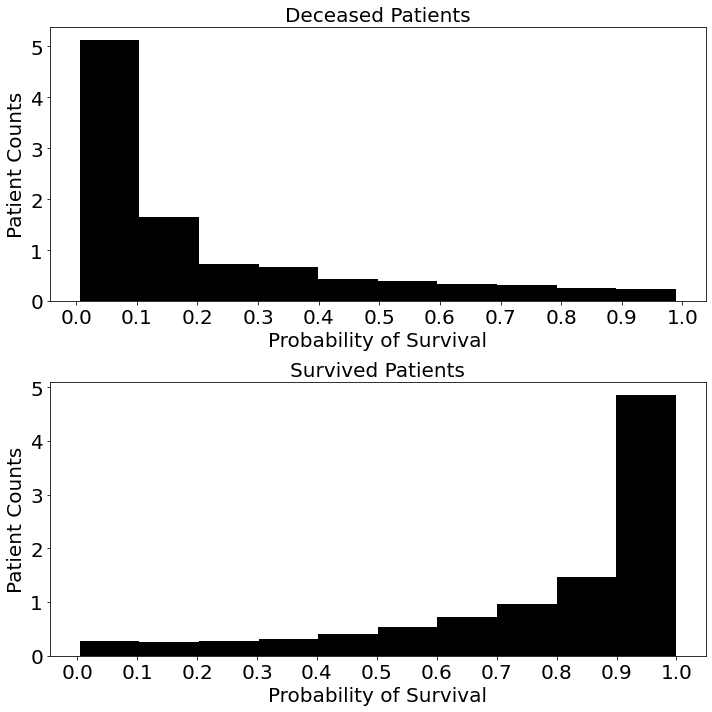

In [66]:
deceased_df = pd.concat([true_death_pred,false_surv_pred])
survived_df = pd.concat([false_death_pred,true_surv_pred])
dfs = [deceased_df,survived_df]
case_names = ['Deceased Patients','Survived Patients']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
counter = 0
title_size = 20
tick_size = 20

for d,c in zip(dfs,case_names): 
    if counter < 0.5: 
        alpha,beta = 0,0
    else: 
        alpha,beta = 1,0
        
    if counter == 0:
        color = 'black'
    if counter == 1: 
        color = 'black'
    if counter == 2: 
        color = 'red'
    if counter == 3: 
        color = 'black'
    counter = counter + 1

    temp = d.predicted_outcome_prob.values
    if(counter ==1): 
        print(str(np.sum(temp<0.8)) + ' out of ' + str(temp.shape[0]) + ' are high risk')
        
    print('Mean of case ' + c + ' is : ' + str(np.round(np.mean(temp),2))) 
    print('Skewness of case ' + c + ' is : ' + str(np.round(scipy.stats.skew(temp),2))) 
    hist, bin_edges = np.histogram(temp,bins=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    print(bin_edges)
    print(' ')
    
    axes[alpha].hist(temp, color = color,density=True)
    axes[alpha].set_xlabel('Probability of Survival',fontsize = title_size,color = 'black')
    axes[alpha].set_ylabel('Patient Counts',fontsize = title_size,color = 'black')
    axes[alpha].set_title(c,fontsize = title_size,color = 'black',position = (0.5,0.90))
    axes[alpha].set_xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    if(counter > 0.5):
        axes[alpha].ticklabel_format(style = 'sci',scilimits = (0,3)) 
    axes[alpha].yaxis.offsetText.set_fontsize(tick_size)
    for ticks in axes[alpha].xaxis.get_major_ticks():
        ticks.label.set_fontsize(tick_size)
    for ticks in axes[alpha].yaxis.get_major_ticks():
        ticks.label.set_fontsize(tick_size)
        
fig.tight_layout()
plt.savefig("hist_2", dpi= 300 )
plt.show()

In [67]:
deceased_df.head(5)

,predicted_outcome_prob,true_outcome,AGE,GCSTOT,PULSE,SBP,TEMP,GENDER,RR,OXYSAT
16,0.395024,0.0,19.0,6.0,76.0,148.0,36.1,0.0,10.0,100.0
153,0.048707,0.0,29.0,3.0,189.0,213.0,36.6,1.0,14.0,100.0
178,0.203174,0.0,18.0,3.0,97.0,121.0,36.7,1.0,16.0,99.0
201,0.309756,0.0,86.0,15.0,70.0,85.0,36.6,1.0,18.0,96.0
223,0.024070,0.0,89.0,3.0,71.0,121.0,38.5,0.0,20.0,100.0


In [68]:
plos_scaler = scaler
plos_clf = clf

In [69]:
filename = 'plos_clf.sav'
pickle.dump(plos_clf, open(filename, 'wb'))
filename = 'plos_scaler.sav'
pickle.dump(plos_scaler, open(filename, 'wb'))

In [70]:
og_missing_data_df.head(5)

,INC_KEY,AGE,GENDER,SBP,PULSE,RR,OXYSAT,TEMP,GCSTOT,HOSPDISP,...,History of Peripheral Vascular Disease (PVD),History of angina within 30 days,History of myocardial infarction,Hypertension requiring medication,Major psychiatric illness,COMORBID_NOT_APPLICABLE,COMORBID_NOT_KNOWN/RECOREDED,Other COMORBID,Prematurity,Steroid use
0,160789265,47,Male,117.0,107.0,18,94,-2.0,13,Not Applicable BIU 1,...,0,0,0,0,0,1,0,0,0,0
6,160789267,44,Female,98.0,71.0,16,95,-2.0,8,Discharged to home or self-care (routine disch...,...,0,0,0,0,0,1,0,0,0,0
14,160788894,63,Male,-1.0,-1.0,-1,-1,-2.0,-1,Not Applicable BIU 1,...,0,0,0,1,0,0,0,0,0,0
16,160684943,86,Female,-2.0,-2.0,-2,-2,-2.0,-2,Discharged/Transferred to Skilled Nursing Faci...,...,0,0,0,1,1,0,0,1,0,0
20,160873553,-99,Female,-1.0,-1.0,-1,-1,-2.0,-1,Discharged to home or self-care (routine disch...,...,0,0,0,0,0,1,0,0,0,0


In [71]:
common = all_data_inc_missing.merge(clean_data_df,on=['INC_KEY','INC_KEY'])
missing_data_df = all_data_inc_missing[(~all_data_inc_missing.INC_KEY.isin(common.INC_KEY))]
missing_data_df.head(5)

,INC_KEY,AGE,GENDER,SBP,PULSE,RR,OXYSAT,TEMP,GCSTOT,HOSPDISP,...,History of Peripheral Vascular Disease (PVD),History of angina within 30 days,History of myocardial infarction,Hypertension requiring medication,Major psychiatric illness,COMORBID_NOT_APPLICABLE,COMORBID_NOT_KNOWN/RECOREDED,Other COMORBID,Prematurity,Steroid use
0,160789265,47,Male,117.0,107.0,18,94,-2.0,13,Not Applicable BIU 1,...,0,0,0,0,0,1,0,0,0,0
6,160789267,44,Female,98.0,71.0,16,95,-2.0,8,Discharged to home or self-care (routine disch...,...,0,0,0,0,0,1,0,0,0,0
14,160788894,63,Male,-1.0,-1.0,-1,-1,-2.0,-1,Not Applicable BIU 1,...,0,0,0,1,0,0,0,0,0,0
16,160684943,86,Female,-2.0,-2.0,-2,-2,-2.0,-2,Discharged/Transferred to Skilled Nursing Faci...,...,0,0,0,1,1,0,0,1,0,0
20,160873553,-99,Female,-1.0,-1.0,-1,-1,-2.0,-1,Discharged to home or self-care (routine disch...,...,0,0,0,0,0,1,0,0,0,0


In [72]:
missing_data_df.loc[missing_data_df['GENDER']  == 'Not Known/Not Recorded BIU 2', 'GENDER'] = 'Male'
missing_data_df["GENDER"] = lb_make.fit_transform(missing_data_df["GENDER"])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [73]:
missing_data_df.GENDER.value_counts()

1    206483
0    143786
Name: GENDER, dtype: int64

In [74]:
missing_data_df = missing_data_df.drop(columns = ['HOSPDISP'])

In [75]:
missing_data_df[missing_data_df < 0] = np.nan

In [76]:
missing_data_df.head(5)

,INC_KEY,AGE,GENDER,SBP,PULSE,RR,OXYSAT,TEMP,GCSTOT,Advanced directive limiting care,...,History of Peripheral Vascular Disease (PVD),History of angina within 30 days,History of myocardial infarction,Hypertension requiring medication,Major psychiatric illness,COMORBID_NOT_APPLICABLE,COMORBID_NOT_KNOWN/RECOREDED,Other COMORBID,Prematurity,Steroid use
0,160789265,47.0,1,117.0,107.0,18.0,94.0,NaN,13.0,0,...,0,0,0,0,0,1,0,0,0,0
6,160789267,44.0,0,98.0,71.0,16.0,95.0,NaN,8.0,0,...,0,0,0,0,0,1,0,0,0,0
14,160788894,63.0,1,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,1,0,0,0,0,0,0
16,160684943,86.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,1,1,0,0,1,0,0
20,160873553,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,1,0,0,0,0


In [77]:
missing_flags = missing_data_df.isnull()*1
missing_flags.head(5)

,INC_KEY,AGE,GENDER,SBP,PULSE,RR,OXYSAT,TEMP,GCSTOT,Advanced directive limiting care,...,History of Peripheral Vascular Disease (PVD),History of angina within 30 days,History of myocardial infarction,Hypertension requiring medication,Major psychiatric illness,COMORBID_NOT_APPLICABLE,COMORBID_NOT_KNOWN/RECOREDED,Other COMORBID,Prematurity,Steroid use
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
20,0,1,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
missing_flags["sum"] = missing_flags['AGE'] + missing_flags['GENDER']+missing_flags['SBP']+missing_flags['PULSE']+\
missing_flags['RR'] + missing_flags['OXYSAT'] + missing_flags['TEMP'] + missing_flags['GCSTOT']
missing_flags.head(5)

,INC_KEY,AGE,GENDER,SBP,PULSE,RR,OXYSAT,TEMP,GCSTOT,Advanced directive limiting care,...,History of angina within 30 days,History of myocardial infarction,Hypertension requiring medication,Major psychiatric illness,COMORBID_NOT_APPLICABLE,COMORBID_NOT_KNOWN/RECOREDED,Other COMORBID,Prematurity,Steroid use,sum
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
14,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,6
16,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,6
20,0,1,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,7


In [79]:
missing_data_df = pd.concat([missing_data_df,missing_flags['sum']],axis=1)
missing_data_df.head(5)

,INC_KEY,AGE,GENDER,SBP,PULSE,RR,OXYSAT,TEMP,GCSTOT,Advanced directive limiting care,...,History of angina within 30 days,History of myocardial infarction,Hypertension requiring medication,Major psychiatric illness,COMORBID_NOT_APPLICABLE,COMORBID_NOT_KNOWN/RECOREDED,Other COMORBID,Prematurity,Steroid use,sum
0,160789265,47.0,1,117.0,107.0,18.0,94.0,NaN,13.0,0,...,0,0,0,0,1,0,0,0,0,1
6,160789267,44.0,0,98.0,71.0,16.0,95.0,NaN,8.0,0,...,0,0,0,0,1,0,0,0,0,1
14,160788894,63.0,1,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,1,0,0,0,0,0,0,6
16,160684943,86.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,1,1,0,0,1,0,0,6
20,160873553,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,1,0,0,0,0,7


In [80]:
missing_data_df = missing_data_df[missing_data_df['sum'] < 2.5]
missing_data_df.head(5)

,INC_KEY,AGE,GENDER,SBP,PULSE,RR,OXYSAT,TEMP,GCSTOT,Advanced directive limiting care,...,History of angina within 30 days,History of myocardial infarction,Hypertension requiring medication,Major psychiatric illness,COMORBID_NOT_APPLICABLE,COMORBID_NOT_KNOWN/RECOREDED,Other COMORBID,Prematurity,Steroid use,sum
0,160789265,47.0,1,117.0,107.0,18.0,94.0,NaN,13.0,0,...,0,0,0,0,1,0,0,0,0,1
6,160789267,44.0,0,98.0,71.0,16.0,95.0,NaN,8.0,0,...,0,0,0,0,1,0,0,0,0,1
28,160039662,NaN,0,120.0,64.0,20.0,98.0,NaN,15.0,1,...,0,0,1,0,0,0,1,0,0,2
34,160177090,19.0,1,110.0,98.0,10.0,98.0,NaN,15.0,0,...,0,0,0,0,1,0,0,0,0,1
46,160177414,10.0,1,118.0,92.0,12.0,94.0,NaN,15.0,0,...,0,0,0,0,1,0,0,0,0,1


In [81]:
extra_df = missing_data_df[['Advanced directive limiting care', 'Alcohol Use Disorder', \
                           'Attention deficit disorder/attention deficit hyperactivity disorder (ADD/ADHD)', \
                           'Bleeding Disorder', 'Cerebrovascular Accident (CVA)', \
                           'Chronic Obstructive Pulmonary Disease (COPD)', 'Chronic renal failure', 'Cirrhosis',\
                           'Congenital Anomalies', 'Congestive heart failure', 'Current smoker', \
                           'Currently receiving chemotherapy for cancer', 'Dementia', 'Diabetes mellitus', \
                           'Disseminated cancer', 'Drug use disorder', 'Functionally dependent health status',\
                           'History of Peripheral Vascular Disease (PVD)', 'History of angina within 30 days', \
                           'History of myocardial infarction', 'Hypertension requiring medication', \
                           'Major psychiatric illness', \
                           'Prematurity', 'Steroid use']]
extra_df.head(5)

,Advanced directive limiting care,Alcohol Use Disorder,Attention deficit disorder/attention deficit hyperactivity disorder (ADD/ADHD),Bleeding Disorder,Cerebrovascular Accident (CVA),Chronic Obstructive Pulmonary Disease (COPD),Chronic renal failure,Cirrhosis,Congenital Anomalies,Congestive heart failure,...,Disseminated cancer,Drug use disorder,Functionally dependent health status,History of Peripheral Vascular Disease (PVD),History of angina within 30 days,History of myocardial infarction,Hypertension requiring medication,Major psychiatric illness,Prematurity,Steroid use
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
34,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
extra_df = extra_df.reset_index(drop=True)

In [83]:
temp_imputed_df = pd.concat([missing_data_imputed_df,extra_df],axis=1)

In [84]:
clean_data_df.head(5)

,INC_KEY,OUTCOME,AGE,GENDER,SBP,PULSE,RR,OXYSAT,TEMP,GCSTOT,...,Disseminatedcancer,Drugusedisorder,Functionallydependenthealthstatus,HistoryofPeripheralVascularDisease(PVD),Historyofanginawithin30days,Historyofmyocardialinfarction,Hypertensionrequiringmedication,Majorpsychiatricillness,Prematurity,Steroiduse
3,160941719,1,52,1,109.0,75.0,14,98,37.1,13,...,0,0,0,0,0,0,1,0,0,0
5,160684936,1,25,1,128.0,69.0,18,98,36.7,15,...,0,0,0,0,0,0,0,0,0,0
9,160039800,1,46,0,120.0,70.0,20,100,36.6,13,...,0,0,0,0,0,0,0,0,0,0
11,160943123,1,18,1,129.0,72.0,16,100,36.8,8,...,0,0,0,0,0,0,0,0,0,0
13,160380204,1,86,0,109.0,84.0,16,93,36.9,15,...,0,0,0,0,0,0,0,0,0,0


In [85]:
feature_list = ['INC_KEY', 'OUTCOME', 'AGE', 'GENDER', 'SBP', 'PULSE', 'RR', 'OXYSAT',
       'TEMP', 'GCSTOT', 'Advanceddirectivelimitingcare', 'AlcoholUseDisorder',
       'Attentiondeficitdisorder/attentiondeficithyperactivitydisorder(ADD/ADHD)',
       'BleedingDisorder', 'CerebrovascularAccident(CVA)',
       'ChronicObstructivePulmonaryDisease(COPD)', 'Chronicrenalfailure',
       'Cirrhosis', 'CongenitalAnomalies', 'Congestiveheartfailure',
       'Currentsmoker', 'Currentlyreceivingchemotherapyforcancer', 'Dementia',
       'Diabetesmellitus', 'Disseminatedcancer', 'Drugusedisorder',
       'Functionallydependenthealthstatus',
       'HistoryofPeripheralVascularDisease(PVD)',
       'Historyofanginawithin30days', 'Historyofmyocardialinfarction',
       'Hypertensionrequiringmedication', 'Majorpsychiatricillness',
                'Prematurity', 'Steroiduse']

clean_data_df = clean_data_df[feature_list]

In [86]:
temp_imputed_df.columns = temp_imputed_df.columns.str.replace(' ', '')

In [87]:
temp_imputed_df = temp_imputed_df[feature_list]

In [88]:
train_imputation_df,test_imputation_df = utils.train_test_creator_CI(temp_imputed_df,training_percent,'OUTCOME')
print('finished constructing imputation datasets')

finished constructing imputation datasets


In [89]:
train_df,test_df = utils.train_test_creator_CI(clean_data_df,training_percent,'OUTCOME')
print('finished constructing clean datasets')

finished constructing clean datasets


In [90]:
feature_list.remove('OUTCOME')

In [91]:
X_train,X_test,y_train,y_test = utils.constructSets(train_df,test_df,feature_list,'OUTCOME')
X_train_imputation,X_test_imputation,y_train_imputation,y_test_imputation = \
utils.constructSets(train_imputation_df,test_imputation_df,feature_list,'OUTCOME')

In [92]:
X_train,y_train = utils.combineSets(X_train,X_train_imputation,y_train,y_train_imputation,train_set_imp_flag) 
X_test,y_test = utils.combineSets(X_test,X_test_imputation,y_test,y_test_imputation,test_set_imp_flag)

In [93]:
scaler = MinMaxScaler()
scaler.fit(X_train.values)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [94]:
clf = GradientBoostingClassifier(max_features = 'auto',learning_rate = learning_rate,\
                               loss = 'deviance',n_estimators = 400,subsample = 0.85,max_depth=3,
                                random_state = random_state)
c, r = y_train.values.shape

In [95]:
clf.fit(X_train, y_train.values.reshape(c,))
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[::,1]
    
fpr, tpr, _ = metrics.roc_curve(y_test.values,  y_pred_proba)
auc_test = metrics.roc_auc_score(y_test.values, y_pred_proba)
    
print('TEST AUC : ' + str(auc_test))

y_pred_proba2 = y_pred_proba
labels_test2 = y_test.values

TEST AUC : 0.9330821249166067


TEST AUC : 0.9223979217780536
TEST AUC : 0.9330821249166067


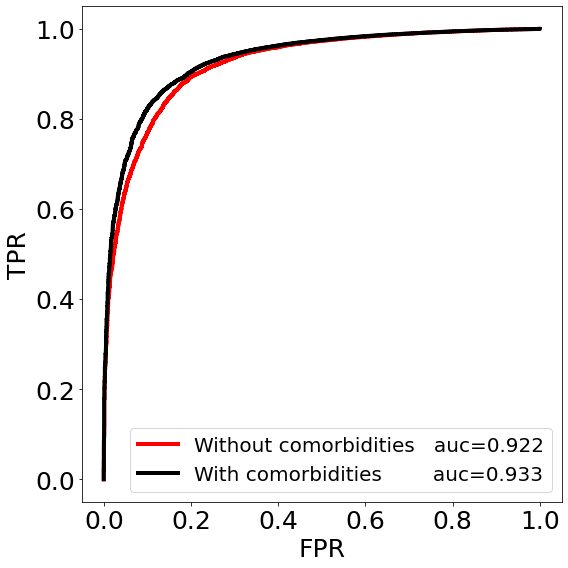

In [96]:
#Code to create Fig. 2
title_size = 25
tick_size = title_size
nrows,ncols = 1,1
dim = 8
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(dim, dim))
alpha,beta = 0,0

feature_list1 = feature_list
feature_list2 = ['AGE','GCSTOT','PULSE','SBP','TEMP','GENDER','RR','OXYSAT']
feature_list3 = []


color_list = ['red','black']
leg_list = [ 'Without comorbidities   ','With comorbidities        ']
y_pred_proba_list = [y_pred_proba1,y_pred_proba2]
labels_test_list = [labels_test1,labels_test2]

for y_pred_proba,labels_test,color,leg in zip(y_pred_proba_list,labels_test_list,color_list,leg_list): 
    
    #y_pred_proba = clf.predict_proba(test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(labels_test,  y_pred_proba)
    auc_test = metrics.roc_auc_score(labels_test, y_pred_proba)
    
    print('TEST AUC : ' + str(auc_test))
    axes.plot(fpr,tpr,color=color,linewidth=4,label=leg+"auc="+str(np.round(auc_test,3)))
    axes.set_xlabel('FPR',fontsize = title_size,color = 'black')
    axes.set_ylabel('TPR',fontsize = title_size,color = 'black')
    for ticks in axes.xaxis.get_major_ticks():
        ticks.label.set_fontsize(tick_size)
    for ticks in axes.yaxis.get_major_ticks(): 
        ticks.label.set_fontsize(tick_size)

fig.tight_layout() 
plt.legend(loc=4, prop={'size': 20})
plt.savefig("ROC_CURVES", dpi= 300 )
plt.show()